In [1]:
import librosa
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
%matplotlib inline


In [2]:
# プロジェクトルートを取得（notebooks/から実行されることを想定）
PROJECT_ROOT = Path.cwd().parent if Path.cwd().name == "notebooks" else Path.cwd()
DATA_ROOT = PROJECT_ROOT / "data" / "jvs_ver1" / "jvs_ver1"

SPEAKER_ID = "jvs002"  # ベースとなる女性話者

wav_dir = DATA_ROOT / SPEAKER_ID / "parallel100" / "wav24kHz16bit"
lab_mon_dir = DATA_ROOT / SPEAKER_ID / "parallel100" / "lab" / "mon"
transcript_path = DATA_ROOT / SPEAKER_ID / "parallel100" / "transcripts_utf8.txt"

print("WAV dir:", wav_dir)
print("MON lab dir:", lab_mon_dir)
print("Transcript file:", transcript_path)

wav_files = sorted(wav_dir.glob("*.wav"))
print("Num wav files:", len(wav_files))
print(wav_files[:5])


WAV dir: /mnt/c/dev/minimal-feature-corpus-tts/data/jvs_ver1/jvs_ver1/jvs002/parallel100/wav24kHz16bit
MON lab dir: /mnt/c/dev/minimal-feature-corpus-tts/data/jvs_ver1/jvs_ver1/jvs002/parallel100/lab/mon
Transcript file: /mnt/c/dev/minimal-feature-corpus-tts/data/jvs_ver1/jvs_ver1/jvs002/parallel100/transcripts_utf8.txt
Num wav files: 100
[PosixPath('/mnt/c/dev/minimal-feature-corpus-tts/data/jvs_ver1/jvs_ver1/jvs002/parallel100/wav24kHz16bit/VOICEACTRESS100_001.wav'), PosixPath('/mnt/c/dev/minimal-feature-corpus-tts/data/jvs_ver1/jvs_ver1/jvs002/parallel100/wav24kHz16bit/VOICEACTRESS100_002.wav'), PosixPath('/mnt/c/dev/minimal-feature-corpus-tts/data/jvs_ver1/jvs_ver1/jvs002/parallel100/wav24kHz16bit/VOICEACTRESS100_003.wav'), PosixPath('/mnt/c/dev/minimal-feature-corpus-tts/data/jvs_ver1/jvs_ver1/jvs002/parallel100/wav24kHz16bit/VOICEACTRESS100_004.wav'), PosixPath('/mnt/c/dev/minimal-feature-corpus-tts/data/jvs_ver1/jvs_ver1/jvs002/parallel100/wav24kHz16bit/VOICEACTRESS100_005.wav')

VOICEACTRESS100_001.wav 7.509333333333333 sec sr= 24000


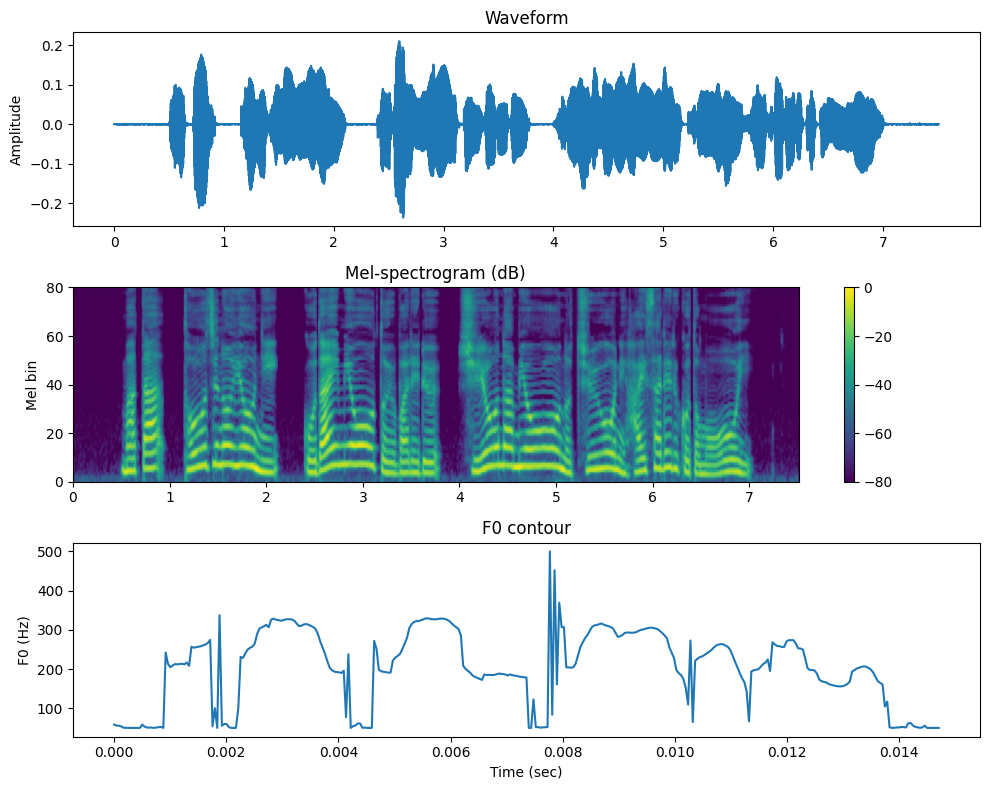

In [3]:
# 1ファイルだけ可視化（動作チェック）
wav_path = wav_files[0]
y, sr = librosa.load(wav_path, sr=None, mono=True)

print(wav_path.name, len(y) / sr, "sec", "sr=", sr)

# メルスペクトログラム
mel = librosa.feature.melspectrogram(
    y=y, sr=sr, n_fft=1024, hop_length=256, n_mels=80
)
mel_db = librosa.power_to_db(mel, ref=np.max)

# F0推定（簡易版: librosa.yin）
f0 = librosa.yin(y, fmin=50, fmax=500, sr=sr)

fig, axs = plt.subplots(3, 1, figsize=(10, 8), sharex=False)
axs[0].plot(np.linspace(0, len(y)/sr, len(y)), y)
axs[0].set_title("Waveform")
axs[0].set_ylabel("Amplitude")

img = axs[1].imshow(mel_db, origin="lower", aspect="auto",
                    extent=[0, len(y)/sr, 0, mel_db.shape[0]])
axs[1].set_title("Mel-spectrogram (dB)")
axs[1].set_ylabel("Mel bin")
fig.colorbar(img, ax=axs[1])

axs[2].plot(np.linspace(0, len(f0)/sr, len(f0)), f0)
axs[2].set_title("F0 contour")
axs[2].set_xlabel("Time (sec)")
axs[2].set_ylabel("F0 (Hz)")

plt.tight_layout()
plt.show()


In [4]:
# 全100文の特徴量を保存
out_dir = PROJECT_ROOT / "outputs" / "features" / SPEAKER_ID / "parallel100"
out_dir.mkdir(parents=True, exist_ok=True)

def extract_features(y, sr):
    """メルスペクトログラムとF0を抽出"""
    mel = librosa.feature.melspectrogram(
        y=y, sr=sr, n_fft=1024, hop_length=256, n_mels=80
    )
    mel_db = librosa.power_to_db(mel, ref=np.max)
    f0 = librosa.yin(y, fmin=50, fmax=500, sr=sr)
    return mel_db, f0

for i, wav_path in enumerate(wav_files):
    y, sr = librosa.load(wav_path, sr=None, mono=True)
    mel_db, f0 = extract_features(y, sr)
    
    base = wav_path.stem  # VOICEACTRESS100_XXX
    np.save(out_dir / f"{base}_mel.npy", mel_db)
    np.save(out_dir / f"{base}_f0.npy", f0)
    
    if (i + 1) % 10 == 0:
        print(f"Processed {i + 1}/{len(wav_files)} files...")

print(f"\nSaved features to: {out_dir}")
print(f"Total files: {len(list(out_dir.glob('*.npy')))}")


Processed 10/100 files...
Processed 20/100 files...
Processed 30/100 files...
Processed 40/100 files...
Processed 50/100 files...
Processed 60/100 files...
Processed 70/100 files...
Processed 80/100 files...
Processed 90/100 files...
Processed 100/100 files...

Saved features to: /mnt/c/dev/minimal-feature-corpus-tts/outputs/features/jvs002/parallel100
Total files: 200
